In [1]:
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset, load_dataset

In [2]:
# load data into training, valdidation and test
dataset = load_dataset('csv', data_files={'train':['hansen_d_bert_ds1.csv', 'hansen_d_bert_ds2.csv',
                                                   'hansen_d_bert_ds3.csv', 'hansen_d_bert_ds4.csv'],
                                          'validation':'hansen_d_bert_ds5.csv',
                                          'test': 'hansen_d_bert_ds6.csv'}, delimiter=',', column_names =['smiles', 'label'])

Using custom data configuration default-b6509ab990ce4a0e


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/pj11/.cache/huggingface/datasets/csv/default-b6509ab990ce4a0e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# check data format
dataset['validation'][1]

{'smiles': 'CC\\C(C)=N\\O', 'label': 14.7}

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# specify model from hugging face
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def tokenize_function(examples):
    return tokenizer(examples["smiles"], padding="max_length", truncation=True)

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
    test: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
})

In [7]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=random_state).select(range(1000))
#small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=random_state).select(range(1000))

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["validation"]
small_test_dataset = tokenized_datasets["test"]

In [8]:
# for regression, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", num_labels=1)

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and a

In [9]:
import evaluate
import numpy as np

In [10]:
# define metric
mae_metric = evaluate.load("mae")
mse_metric = evaluate.load("mse")
pearsonr_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    # print(eval_pred)
    #logits, labels = eval_pred
    #predictions = np.argmax(logits, axis=-1)
    predictions, labels = eval_pred
    
    metrics = {}
    metrics.update({'mae': mae_metric.compute(predictions=predictions, references=labels)})
    metrics.update({'rmse': mse_metric.compute(predictions=predictions, references=labels, squared=False)})
    metrics.update({'pearsonr': pearsonr_metric.compute(predictions=predictions, references=labels)})
    
    return metrics

In [11]:
# directory to save the finetuned model
para_output_dir = 'C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1/'
model_output_path = f'{para_output_dir}/model'

# specify trainining arguments 
training_args = TrainingArguments(output_dir=para_output_dir, 
                                  evaluation_strategy="epoch",
                                  #per_device_train_batch_size = 64,
                                  #per_device_eval_batch_size = 64,
                                  num_train_epochs=50)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [13]:
# finetuning
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 789
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 44104705
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Wa

Epoch,Training Loss,Validation Loss,Mae,Rmse,Pearsonr
1,No log,55.576160,{'mae': 7.223409047586664},{'mse': 7.457740726145153},{'pearsonr': 0.08701955853098609}
2,No log,24.270010,{'mae': 4.5748671081465515},{'mse': 4.929453583184772},{'pearsonr': 0.030872241552578568}
3,No log,12.977970,{'mae': 3.1434673173778553},{'mse': 3.605711150536933},{'pearsonr': 0.045574993397273875}
4,No log,7.197320,{'mae': 2.0996739392353194},{'mse': 2.6861878953582616},{'pearsonr': 0.06685095911032571}
5,No log,4.283473,{'mae': 1.5658483263199705},{'mse': 2.073023447589096},{'pearsonr': 0.08346354734677303}
6,No log,3.473547,{'mae': 1.524745127876398},{'mse': 1.8666746191498131},{'pearsonr': 0.5793395834195899}
7,No log,2.485485,{'mae': 1.1856397057547787},{'mse': 1.5802231829741324},{'pearsonr': 0.7988154780857367}
8,No log,1.522821,{'mae': 0.9297629612956555},{'mse': 1.2347726087317894},{'pearsonr': 0.8421307833882609}
9,No log,1.244070,{'mae': 0.8367156643552829},{'mse': 1.1180303992346787},{'pearsonr': 0.870603324210816}
10,No log,1.004166,{'mae': 0.7324277180705578},{'mse': 1.0036657655530243},{'pearsonr': 0.8734972657213289}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

Model weights saved in C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1/checkpoint-1000\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was

  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1250, training_loss=4.41025719909668, metrics={'train_runtime': 519.9286, 'train_samples_per_second': 75.876, 'train_steps_per_second': 2.404, 'total_flos': 5225745681561600.0, 'train_loss': 4.41025719909668, 'epoch': 50.0})

In [14]:
#take care of distributed/paralelle training 
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model 
model_to_save.save_pretrained(model_output_path)

Configuration saved in C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1//model\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1//model\pytorch_model.bin


In [15]:
# making prediction 
model = AutoModelForSequenceClassification.from_pretrained(model_output_path)

# arguments for Trainer
test_args = TrainingArguments(
     output_dir =model_output_path,
     do_train = False,
     do_predict = True,
     dataloader_drop_last = False
)

# Init Trainer
trainer=Trainer(
          model = model,
          args = test_args,
          compute_metrics = compute_metrics)

test_results = trainer.predict(small_test_dataset)

loading configuration file C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1//model\config.json
Model config RobertaConfig {
  "_name_or_path": "C:/Users/pj11/Documents/bert_finetune/hansen_d_cross_val_fold1//model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size

In [16]:
# print out prediction in test set
test_results[1]

array([16.8, 16. , 15.6, 15.7, 17.8, 15.9, 17.2, 17.2, 18.8, 16. , 17.8,
       16.5, 15. , 20. , 20. , 15.2, 15.4, 19.9, 20.2, 14. , 16. , 21. ,
       14.4, 16.8, 17. , 19.4, 15.9, 15.8, 19.6, 19.5, 17.8, 18.7, 19. ,
       19.2, 16.3, 20.3, 16.5, 17.1, 15.8, 18.3, 15.4, 15.4, 20.9, 15.3,
       15.7, 15. , 17.5, 14.7, 15.8, 16. , 19.9, 19. , 15.5, 19.8, 18.5,
       20.3, 16.5, 15.7, 15.7, 15.4, 15.8, 16.8, 16.2, 19. , 16.8, 16.4,
       14.5, 18.7, 18.7, 19. , 16.3, 15.1, 16.8, 20.2, 14.9, 18.2, 20.5,
       18.2, 14.6, 19.1, 15. , 16.4, 15.5, 20.4, 20.1, 15. , 16. , 15.9,
       16.7, 20. , 15.5, 19.2, 15.6, 19.5, 17.3, 16.3, 16.4, 20.2, 17.5,
       17.2, 16.1, 19.8, 18.7, 20. , 19. , 19.4, 15.3, 16.5, 19.5, 16.2,
       20. , 16.9, 15.6, 17.4, 19. , 20. , 20. , 15.8, 19.5, 15.6, 17.5,
       13.7, 19. , 19.2, 17.8, 16. , 16.3, 14.8, 16. , 15.3, 16.1, 17.8,
       17.4, 21.3, 20.2, 18.9, 18.9, 20.7, 14.4, 20. , 17.6, 12.2, 14.6,
       15.2, 16.8, 16.4, 16. , 18.2, 16. , 18.1, 17

In [17]:
# print out metric in test set
test_results[2]

{'test_loss': 0.7187657952308655,
 'test_mae': {'mae': 0.6068708303616132},
 'test_rmse': {'mse': 0.8470046836767883},
 'test_pearsonr': {'pearsonr': 0.9007303605635548},
 'test_runtime': 1.7333,
 'test_samples_per_second': 113.656,
 'test_steps_per_second': 4.039}

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(test_results[0], test_results[1]))

#RMSEs
print(math.sqrt(mean_squared_error(test_results[0], test_results[1])))

# R^2 Coefficient of Determination
print(r2_score(test_results[0], test_results[1]))

0.60687083
0.847004723554859
0.716069752207027


Text(0, 0.5, 'pred. Hansen d')

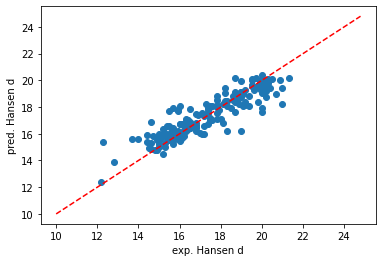

In [20]:
# plot exp vs pred in test set
import matplotlib.pyplot as plt
plt.figure(1)

ln = np.arange(10, 25, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(test_results[1], test_results[0])
plt.xlabel('exp. Hansen d')
plt.ylabel('pred. Hansen d')

In [21]:
pd_pred_test=pd.DataFrame(test_results[0], columns=["predict"])
pd_exp_test=pd.DataFrame(test_results[1], columns=["exp"])
pd_smiles=pd.DataFrame(dataset['test']['smiles'], columns=["smiles"])
pd_test=pd.concat((pd_smiles, pd_exp_test, pd_pred_test), axis=1)

# save predicton to csv 
pd_test.to_csv('hansen_d_bert_ds6_fold1_results.csv')

In [22]:
pd_test

,smiles,exp,predict
0,SC#N,16.799999,16.580278
1,CC1CCCC1,16.000000,16.744991
2,CCCCC(CC)CNCC(CC)CCCC,15.600000,16.126049
3,CCCCCCCCCC,15.700000,15.747732
4,O=C(CCCCCCCCC(=O)OCc1ccccc1)OCc2ccccc2,17.799999,18.508404
...,...,...,...
192,CC=CCC#N,16.400000,16.336565
193,CCCCOC(C)=O,15.800000,16.131983
194,CC(C)=C=O,15.200000,15.892619
195,Fc1cccc(F)c1C#N,18.799999,18.636156
